In [1]:
import os, pymssql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
import torch.nn.functional as F
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
class DenseRFF_PT(nn.Module):
    def __init__(self, Nf, scale=None, gamma=None, normalization=True,
                 function="cos", trainable_scale=True, trainable_W=True,
                 seed=None, kernel='gaussian'):
        super().__init__()
        self.Nf = Nf
        self.gamma = gamma
        self.scale = scale
        self.normalization = normalization
        self.function = function
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.seed = seed
        self.kernel_type = kernel
        self.W = None
        self.b = None
        self.rho_scale = None
        self._eps = 1e-8
        self.bandwidth_history = []

    def _get_random_features_initializer(self, shape, sigma=1.0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        if self.kernel_type == 'gaussian':
            return np.random.randn(*shape) / sigma
        elif self.kernel_type == 'laplacian':
            return np.random.laplace(loc=0.0, scale=1.0, size=shape) / sigma
        else:
            raise ValueError(f'Unsupported initializer {self.kernel_type}')

    def _ensure_params_initialized(self, device, D):
        if self.W is None:
            if self.gamma is not None:
                sigma = np.sqrt(1.0 / (2 * self.gamma))
            else:
                sigma = 1.0
            if self.scale is None:
                self.scale = sigma
            W_init = self._get_random_features_initializer((D, self.Nf),
                                                           sigma=self.scale,
                                                           seed=self.seed)
            self.W = nn.Parameter(torch.tensor(W_init, dtype=torch.float32, device=device),
                                  requires_grad=self.trainable_W)
            b_init = np.random.uniform(0.0, 2 * np.pi, size=(self.Nf,))
            self.b = nn.Parameter(torch.tensor(b_init, dtype=torch.float32, device=device),
                                  requires_grad=self.trainable_W)
            init_kernel_scale = 1.0
            rho0 = np.log(np.exp(init_kernel_scale) - 1.0)
            self.rho_scale = nn.Parameter(
                torch.tensor([rho0], dtype=torch.float32, device=device),
                requires_grad=self.trainable_scale
            )

    def _kernel_scale(self):
        return F.softplus(self.rho_scale) + self._eps

    def bandwidth_lengthscale(self):
        if self.rho_scale is None or self.scale is None:
            return None
        ks = float(self._kernel_scale().detach().cpu().item())
        return float(self.scale) / ks

    @torch.no_grad()
    def log_bandwidth(self, step):
        ell = self.bandwidth_lengthscale()
        if ell is not None:
            self.bandwidth_history.append((step, float(ell)))

    def forward(self, inputs):
        device = inputs.device
        if inputs.dim() == 2:
            inputs = inputs.unsqueeze(1)
        elif inputs.dim() != 3:
            raise ValueError(f"Expected [B,T,D], got {inputs.shape}")
        B, T, D = inputs.shape
        self._ensure_params_initialized(device, D)
        kernel_scale = self._kernel_scale()
        proj = torch.matmul(inputs, self.W * kernel_scale) + self.b
        outputs = torch.cos(proj) * np.sqrt(2.0 / self.Nf)
        if self.normalization:
            norm = np.sqrt(self.Nf)
            outputs = outputs / norm
        return outputs.permute(0, 2, 1)


class SpectralDropout1d(nn.Module):
    def __init__(self, p: float = 0.1, channels_last: bool = True):
        super().__init__()
        self.p = p
        self.channels_last = channels_last
    def forward(self, x):
        if (not self.training) or self.p == 0.0:
            return x
        if self.channels_last:
            B, T, F = x.shape
            mask = (torch.rand(B, 1, F, device=x.device) > self.p).float() / (1.0 - self.p)
            return x * mask
        else:
            B, F, T = x.shape
            mask = (torch.rand(B, F, 1, device=x.device) > self.p).float() / (1.0 - self.p)
            return x * mask


class TemporalSpectralBlock(nn.Module):
    def __init__(self, features, kernel_size=3, dilation=2, p_drop=0.1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(features, features, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(features, features, kernel_size, padding=padding, dilation=1)
        self.norm = nn.LayerNorm(features)
        self.act = nn.GELU()
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):
        res = x
        y = x.transpose(1, 2)
        y = self.act(self.conv1(y))
        y = self.conv2(y).transpose(1, 2)
        if y.size(1) != res.size(1):
            min_len = min(y.size(1), res.size(1))
            y = y[:, :min_len, :]
            res = res[:, :min_len, :]
        y = self.norm(y + res)
        y = self.act(y)
        return self.drop(y)


class MultiBandRFFEncoder(nn.Module):
    def __init__(self, in_dim=1, bands=(4., 24., 168.), nf_per_band=32,
                 kernel="gaussian", spectral_dropout_p=0.1):
        super().__init__()
        self.bands = nn.ModuleList([
            DenseRFF_PT(Nf=nf_per_band, function="cos",
                        trainable_W=True, trainable_scale=True,
                        kernel=kernel, scale=band)
            for band in bands
        ])
        self.out_dim = nf_per_band * len(self.bands)
        self.norm = nn.LayerNorm(self.out_dim)
        self.spec_do = SpectralDropout1d(p=spectral_dropout_p, channels_last=True)
        self.drop = nn.Dropout(spectral_dropout_p)

    def forward(self, x):
        outs = []
        for b in self.bands:
            z = b(x)
            z = z.transpose(1, 2)
            outs.append(z)
        zcat = torch.cat(outs, dim=2)
        zcat = self.norm(zcat)
        zcat = self.drop(self.spec_do(zcat))
        return zcat


class TemporalHead(nn.Module):
    def __init__(self, hidden, horizon, pool="last"):
        super().__init__()
        self.pool = pool
        self.fc1 = nn.Linear(hidden, hidden // 2)
        self.fc2 = nn.Linear(hidden // 2, horizon)
        self.act = nn.ReLU()

    def forward(self, H):
        if self.pool == "mean":
            v = H.mean(dim=1)
        else:
            v = H[:, -1, :]
        return self.fc2(self.act(self.fc1(v)))


class RFF_AnyRNN_Forecaster(nn.Module):
    def __init__(self, horizon=24, rnn_type="LSTM",
                 bands=(4., 24., 168.), nf_per_band=64,
                 hidden=96, num_layers=1, bidirectional=False,
                 use_tsb=True, kernel="gaussian",
                 spectral_dropout_p=0.1, pool="last"):
        super().__init__()
        self.enc = MultiBandRFFEncoder(1, bands, nf_per_band, kernel, spectral_dropout_p)
        self.tsb = TemporalSpectralBlock(self.enc.out_dim) if use_tsb else nn.Identity()
        self.rnn = getattr(nn, rnn_type)(
            input_size=self.enc.out_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        out_hidden = hidden * (2 if bidirectional else 1)
        self.head = TemporalHead(out_hidden, horizon, pool)

    def forward(self, x):
        z = self.enc(x)
        z = self.tsb(z)
        H, _ = self.rnn(z)
        return self.head(H)


In [3]:
conn = pymssql.connect(
    server=os.getenv("DB_SERVER", "localhost"),
    user=os.getenv("DB_USER", "sa"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME", "ClimateDB"),
    port=os.getenv("DB_PORT", "1433")
)


In [4]:
municipios = [
    'albania', 'barrancas', 'distraccion', 'el_molino', 'fonseca',
    'hatonuevo', 'la_jagua_del_pilar', 'maicao', 'manaure', 'mingueo',
    'riohacha', 'san_juan_del_cesar', 'uribia'
]


In [5]:
data_48h = {}
for mun in municipios:
    query = f"""
    SELECT TOP 48 datetime, wind_speed_10m
    FROM climate_observations
    WHERE municipio = '{mun}'
    ORDER BY datetime DESC
    """
    df = pd.read_sql(query, conn)
    df = df.sort_values('datetime').reset_index(drop=True)
    data_48h[mun] = df


/var/folders/t3/97hgmq6x6mg3dybs2fbsfcqr0000gn/T/ipykernel_37047/3520688126.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [6]:
normalization_params = {}
cursor = conn.cursor()

for mun in municipios:
    query = f"""
    SELECT MIN(wind_speed_10m) as min_val, MAX(wind_speed_10m) as max_val
    FROM climate_observations
    WHERE municipio = '{mun}' AND wind_speed_10m IS NOT NULL
    """
    cursor.execute(query)
    result = cursor.fetchone()
    
    normalization_params[mun] = {
        'min': result[0],  # min_val
        'max': result[1]   # max_val
    }
    print(f"✅ {mun}: min={result[0]:.2f}, max={result[1]:.2f}")

cursor.close()

✅ albania: min=0.00, max=25.60
✅ barrancas: min=0.00, max=30.90
✅ distraccion: min=0.00, max=33.30
✅ el_molino: min=0.00, max=36.80
✅ fonseca: min=0.00, max=33.30
✅ hatonuevo: min=0.00, max=26.30
✅ la_jagua_del_pilar: min=0.00, max=45.40
✅ maicao: min=0.00, max=38.50
✅ manaure: min=0.00, max=41.80
✅ mingueo: min=0.00, max=33.20
✅ riohacha: min=0.00, max=44.00
✅ san_juan_del_cesar: min=0.00, max=35.20
✅ uribia: min=0.00, max=41.80


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {}

model_name_map = {
    'albania': 'Albania',
    'barrancas': 'Barrancas',
    'distraccion': 'Distraccion',
    'el_molino': 'El_Molino',
    'fonseca': 'Fonseca',
    'hatonuevo': 'Hatonuevo',
    'la_jagua_del_pilar': 'La_Jagua_del_Pilar',
    'maicao': 'Maicao',
    'manaure': 'Manaure',
    'mingueo': 'Mingueo',
    'riohacha': 'Riohacha',
    'san_juan_del_cesar': 'San_Juan_del_Cesar',
    'uribia': 'Uribia'
}

for mun in municipios:
    model_file = f'../data/models/LSTM/model_LSTM_{model_name_map[mun]}.pt'
    
    # Cargar checkpoint completo
    checkpoint = torch.load(model_file, map_location=device)
    
    # Extraer hiperparámetros guardados
    best_params = checkpoint['best_params']
    
    # Instanciar modelo con los hiperparámetros correctos
    model = RFF_AnyRNN_Forecaster(
        horizon=24,
        rnn_type="LSTM",
        bands=best_params.get('bands', (4., 24., 168.)),
        nf_per_band=best_params.get('nf_per_band', 64),
        hidden=best_params.get('hidden', 96),
        num_layers=best_params.get('num_layers', 1),
        bidirectional=best_params.get('bidirectional', False),
        use_tsb=best_params.get('use_tsb', True),
        kernel=best_params.get('kernel', 'gaussian'),
        spectral_dropout_p=best_params.get('spectral_dropout_p', 0.1),
        pool=best_params.get('pool', 'last')
    )
    
    model.to(device)
    
    # Forward pass dummy para inicializar parámetros diferidos
    with torch.no_grad():
        dummy_input = torch.randn(1, 48, 1).to(device)
        _ = model(dummy_input)
    
    # Ahora cargar los pesos del modelo
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    models[mun] = model
    print(f"✅ Modelo cargado: {mun}")

✅ Modelo cargado: albania
✅ Modelo cargado: barrancas
✅ Modelo cargado: distraccion
✅ Modelo cargado: el_molino
✅ Modelo cargado: fonseca
✅ Modelo cargado: hatonuevo
✅ Modelo cargado: la_jagua_del_pilar
✅ Modelo cargado: maicao
✅ Modelo cargado: manaure
✅ Modelo cargado: mingueo
✅ Modelo cargado: riohacha
✅ Modelo cargado: san_juan_del_cesar
✅ Modelo cargado: uribia


In [8]:
predictions = {}

for mun in municipios:
    wind_data = data_48h[mun]['wind_speed_10m'].values
    
    min_val = normalization_params[mun]['min']
    max_val = normalization_params[mun]['max']
    wind_normalized = (wind_data - min_val) / (max_val - min_val)
    
    X_input = torch.tensor(wind_normalized, dtype=torch.float32).reshape(1, 48, 1).to(device)
    
    with torch.no_grad():
        y_pred_normalized = models[mun](X_input)
    
    # Usar .tolist() en lugar de .numpy()
    y_pred = y_pred_normalized.detach().cpu().tolist()[0]
    y_pred_denormalized = [y * (max_val - min_val) + min_val for y in y_pred]
    
    last_datetime = data_48h[mun]['datetime'].iloc[-1]
    forecast_times = pd.date_range(start=last_datetime, periods=25, freq='H')[1:]
    
    predictions[mun] = pd.DataFrame({
        'datetime': forecast_times,
        'predicted_wind_speed_10m': y_pred_denormalized
    })
    
    print(f"✅ {mun}: Predicción generada para {len(y_pred)} horas")

✅ albania: Predicción generada para 24 horas
✅ barrancas: Predicción generada para 24 horas
✅ distraccion: Predicción generada para 24 horas
✅ el_molino: Predicción generada para 24 horas
✅ fonseca: Predicción generada para 24 horas
✅ hatonuevo: Predicción generada para 24 horas
✅ la_jagua_del_pilar: Predicción generada para 24 horas
✅ maicao: Predicción generada para 24 horas
✅ manaure: Predicción generada para 24 horas
✅ mingueo: Predicción generada para 24 horas
✅ riohacha: Predicción generada para 24 horas
✅ san_juan_del_cesar: Predicción generada para 24 horas
✅ uribia: Predicción generada para 24 horas


/var/folders/t3/97hgmq6x6mg3dybs2fbsfcqr0000gn/T/ipykernel_37047/664134421.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_datetime, periods=25, freq='H')[1:]


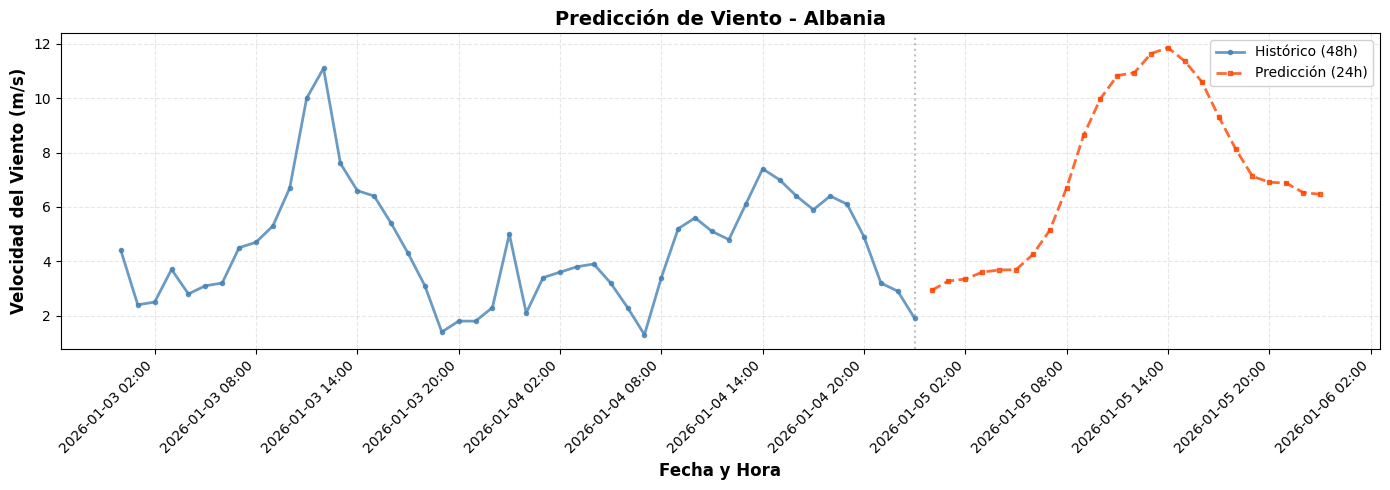


📊 ALBANIA
Histórico: 1.30 - 11.10 m/s (Media: 4.50)
Predicción: 2.93 - 11.86 m/s (Media: 7.24)
Último valor histórico: 1.90 m/s
Primera predicción: 2.93 m/s
Diferencia: 1.03 m/s


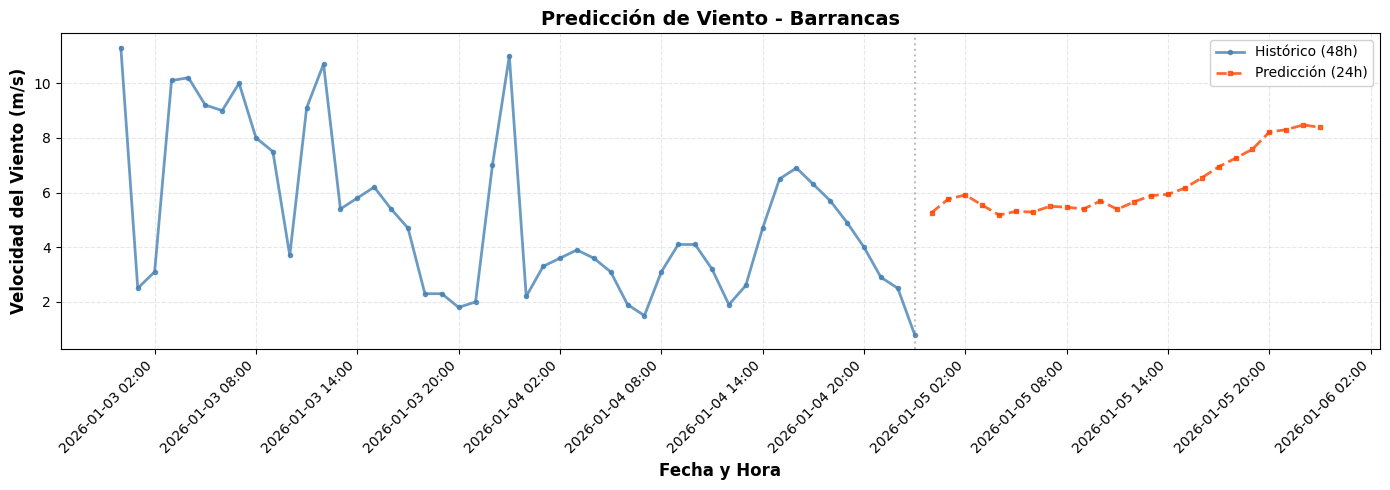


📊 BARRANCAS
Histórico: 0.80 - 11.30 m/s (Media: 5.12)
Predicción: 5.18 - 8.48 m/s (Media: 6.29)
Último valor histórico: 0.80 m/s
Primera predicción: 5.27 m/s
Diferencia: 4.47 m/s


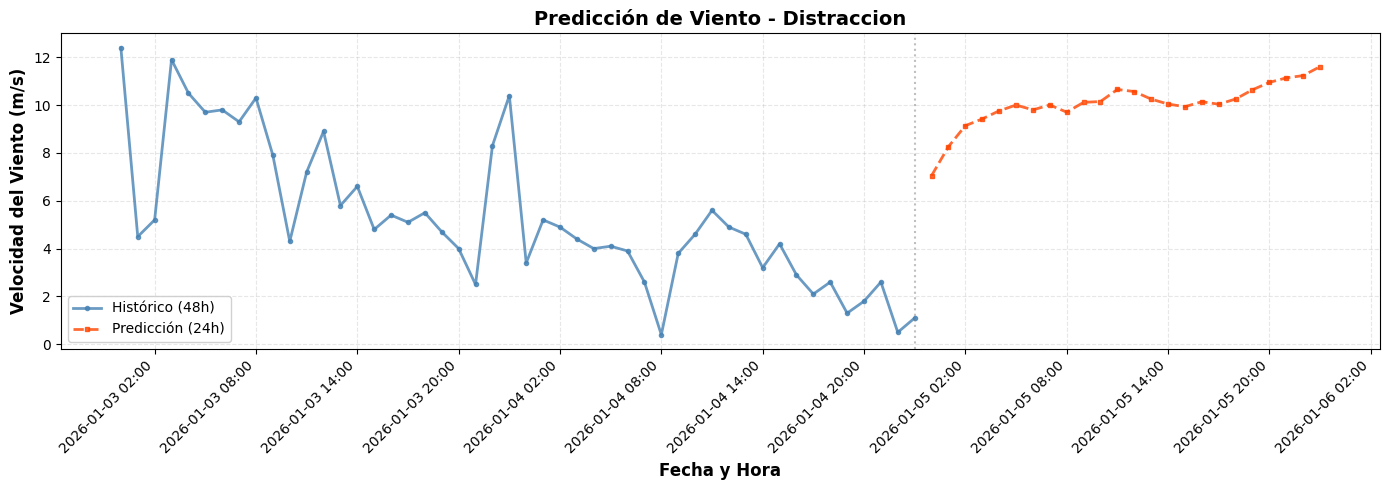


📊 DISTRACCION
Histórico: 0.40 - 12.40 m/s (Media: 5.29)
Predicción: 7.05 - 11.61 m/s (Media: 10.04)
Último valor histórico: 1.10 m/s
Primera predicción: 7.05 m/s
Diferencia: 5.95 m/s


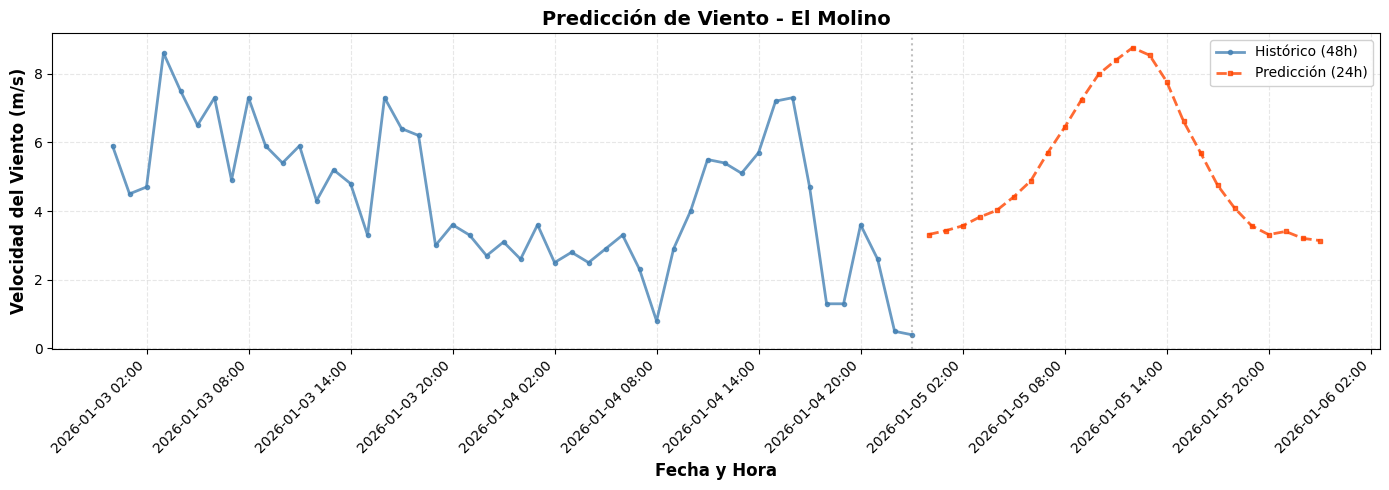


📊 EL_MOLINO
Histórico: 0.40 - 8.60 m/s (Media: 4.34)
Predicción: 3.14 - 8.76 m/s (Media: 5.25)
Último valor histórico: 0.40 m/s
Primera predicción: 3.32 m/s
Diferencia: 2.92 m/s


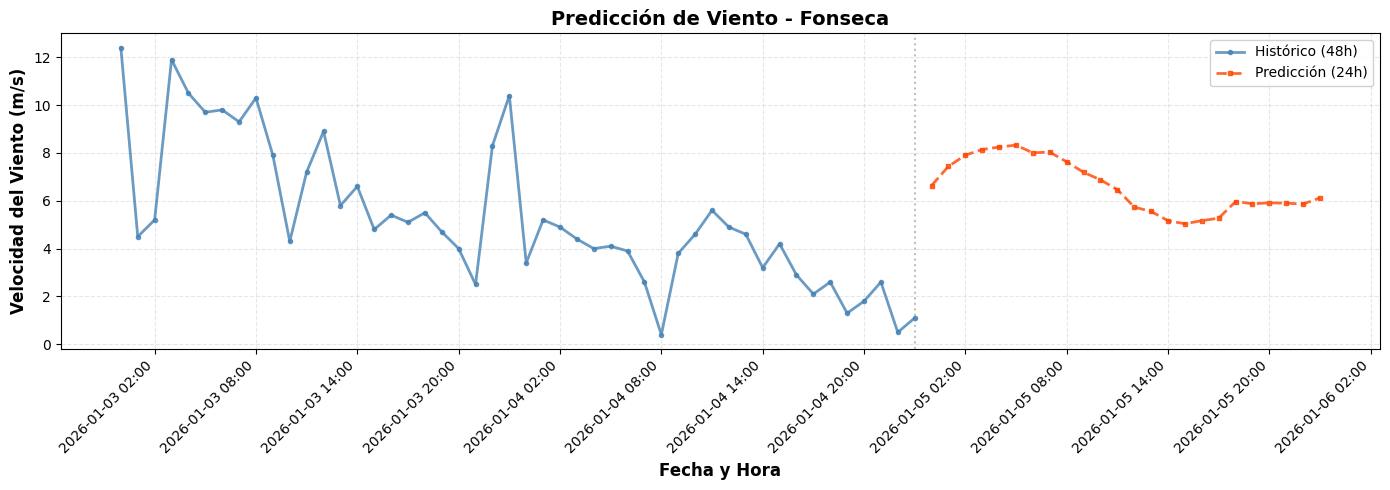


📊 FONSECA
Histórico: 0.40 - 12.40 m/s (Media: 5.29)
Predicción: 5.04 - 8.33 m/s (Media: 6.60)
Último valor histórico: 1.10 m/s
Primera predicción: 6.64 m/s
Diferencia: 5.54 m/s


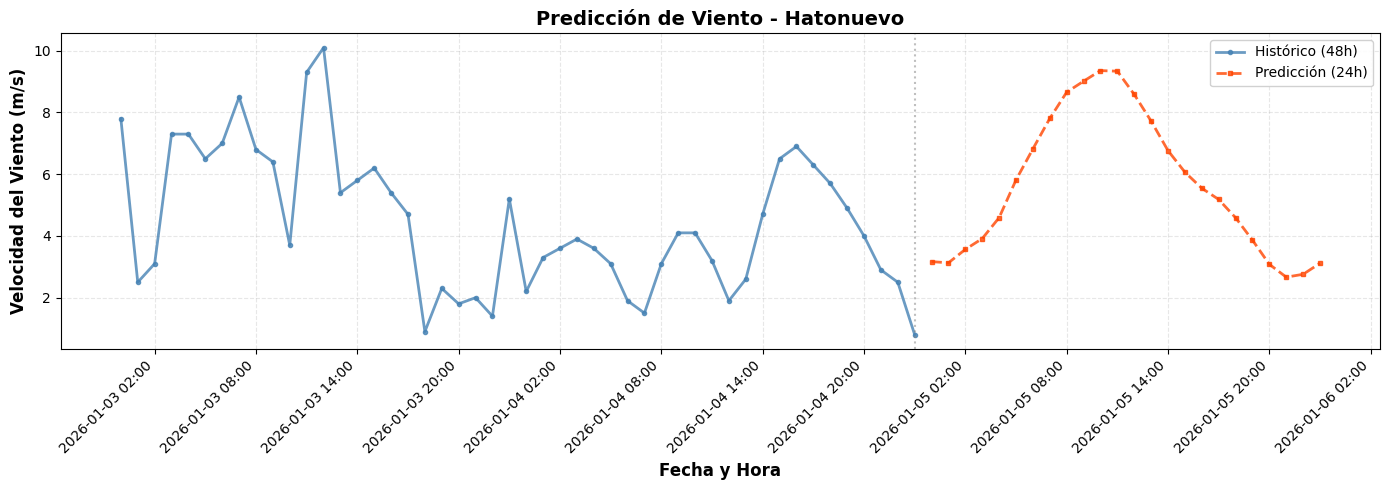


📊 HATONUEVO
Histórico: 0.80 - 10.10 m/s (Media: 4.47)
Predicción: 2.67 - 9.36 m/s (Media: 5.63)
Último valor histórico: 0.80 m/s
Primera predicción: 3.17 m/s
Diferencia: 2.37 m/s


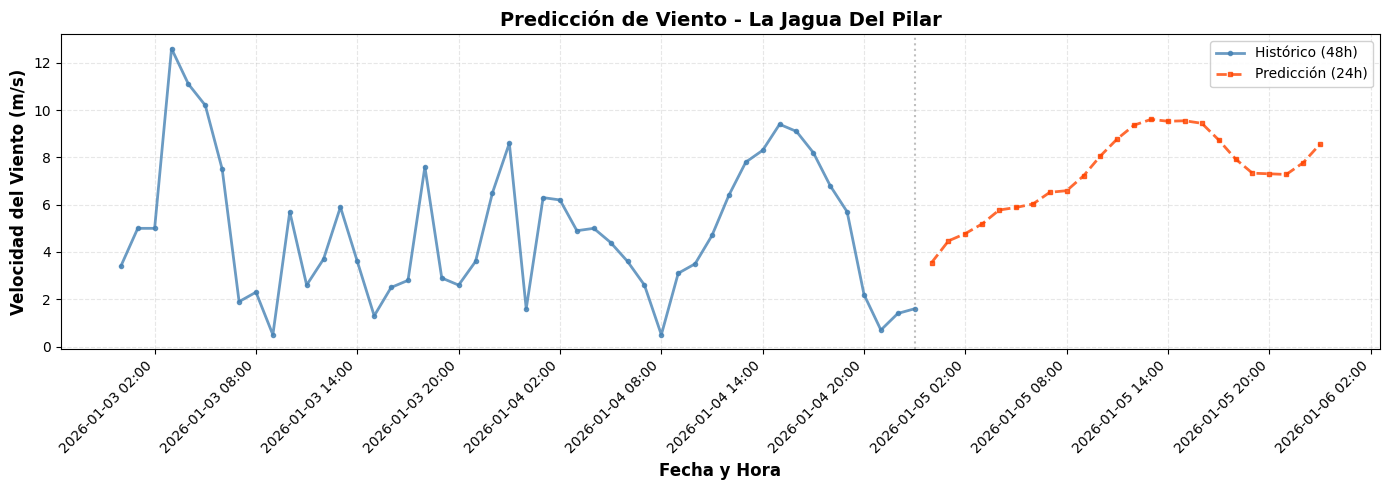


📊 LA_JAGUA_DEL_PILAR
Histórico: 0.50 - 12.60 m/s (Media: 4.86)
Predicción: 3.55 - 9.61 m/s (Media: 7.30)
Último valor histórico: 1.60 m/s
Primera predicción: 3.55 m/s
Diferencia: 1.95 m/s


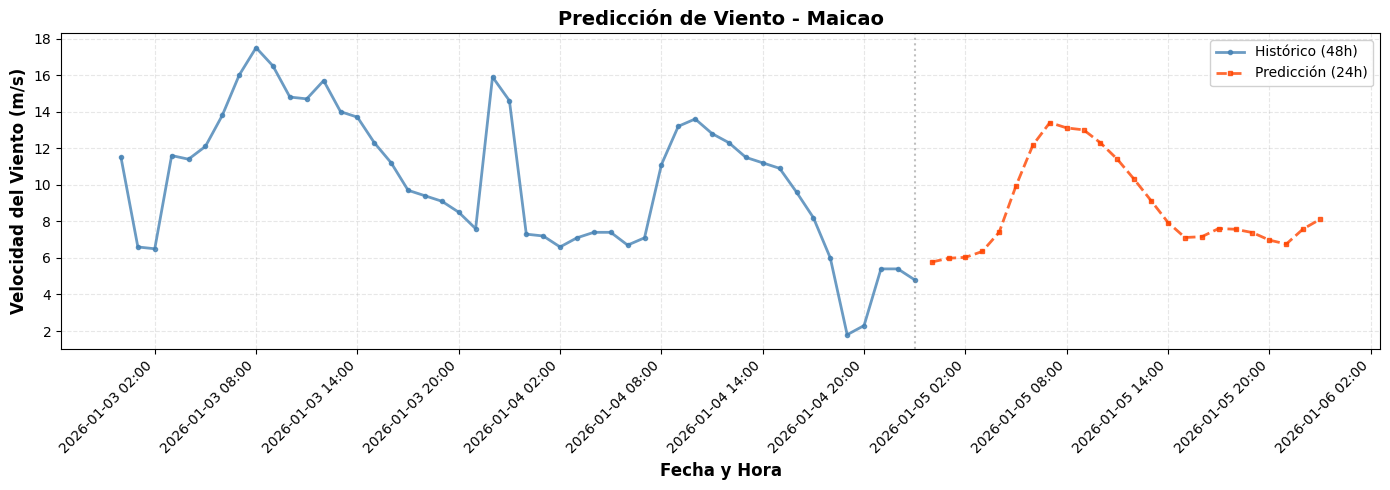


📊 MAICAO
Histórico: 1.80 - 17.50 m/s (Media: 10.24)
Predicción: 5.77 - 13.40 m/s (Media: 8.77)
Último valor histórico: 4.80 m/s
Primera predicción: 5.77 m/s
Diferencia: 0.97 m/s


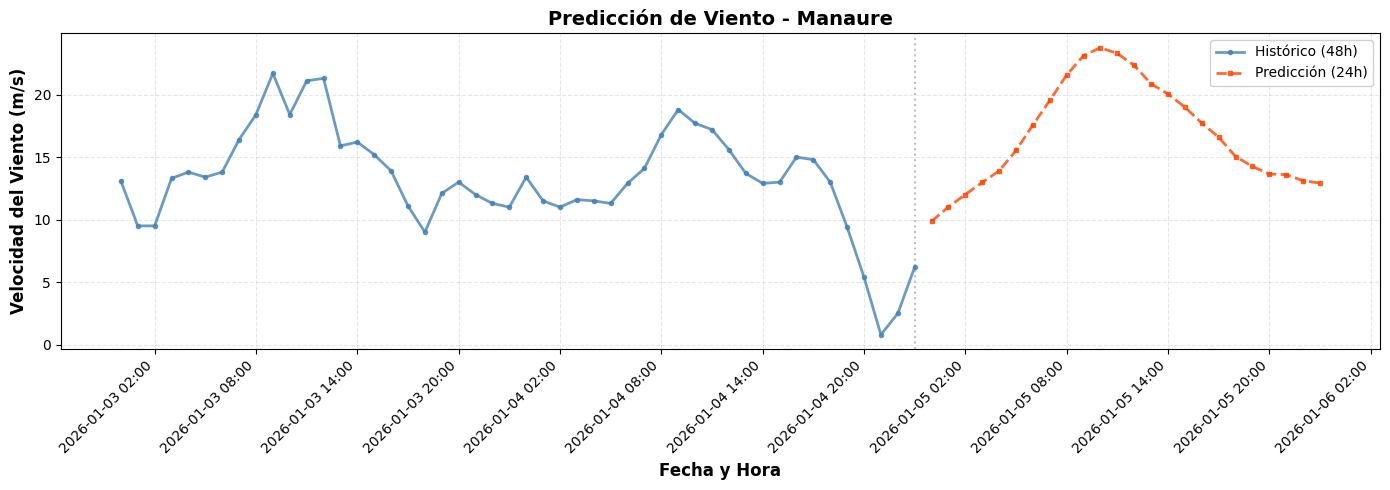


📊 MANAURE
Histórico: 0.80 - 21.70 m/s (Media: 13.22)
Predicción: 9.87 - 23.75 m/s (Media: 16.80)
Último valor histórico: 6.20 m/s
Primera predicción: 9.87 m/s
Diferencia: 3.67 m/s


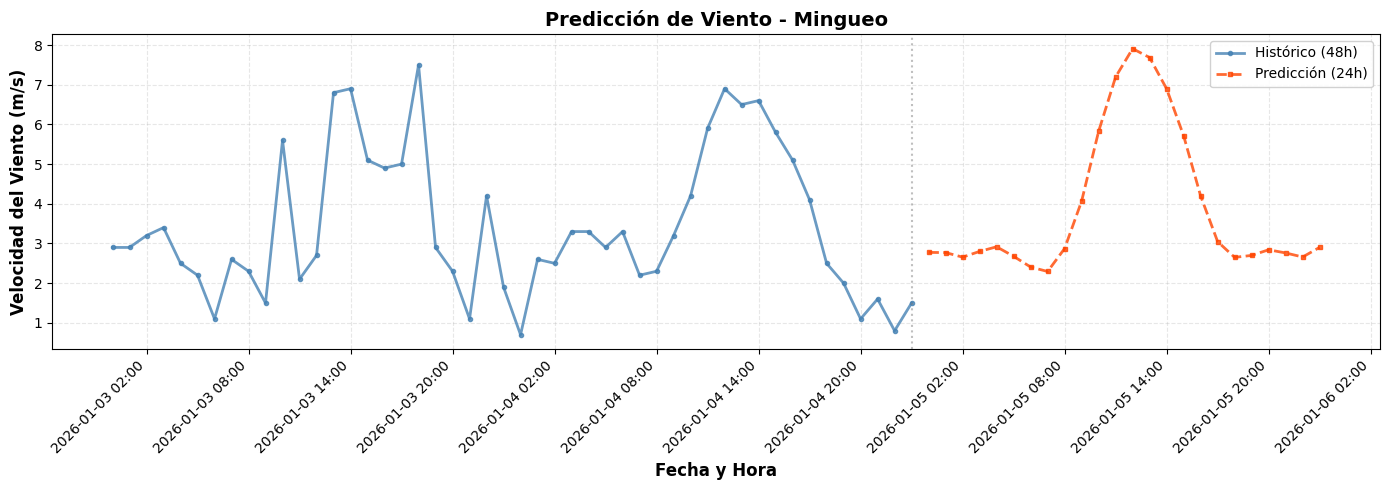


📊 MINGUEO
Histórico: 0.70 - 7.50 m/s (Media: 3.43)
Predicción: 2.29 - 7.91 m/s (Media: 3.88)
Último valor histórico: 1.50 m/s
Primera predicción: 2.77 m/s
Diferencia: 1.27 m/s


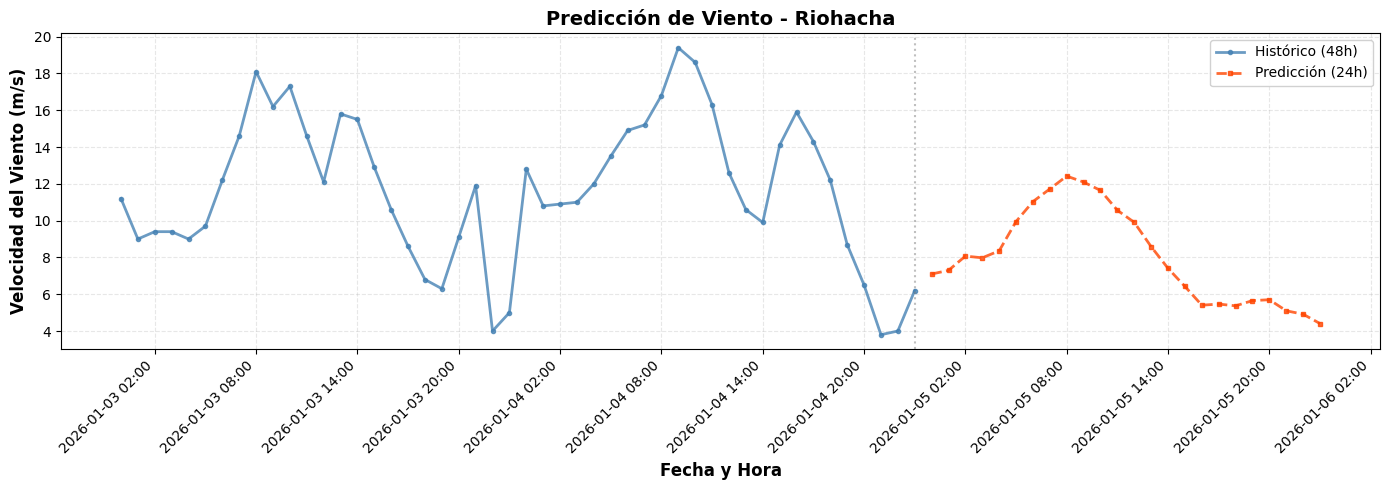


📊 RIOHACHA
Histórico: 3.80 - 19.40 m/s (Media: 11.67)
Predicción: 4.41 - 12.42 m/s (Media: 8.02)
Último valor histórico: 6.20 m/s
Primera predicción: 7.10 m/s
Diferencia: 0.90 m/s


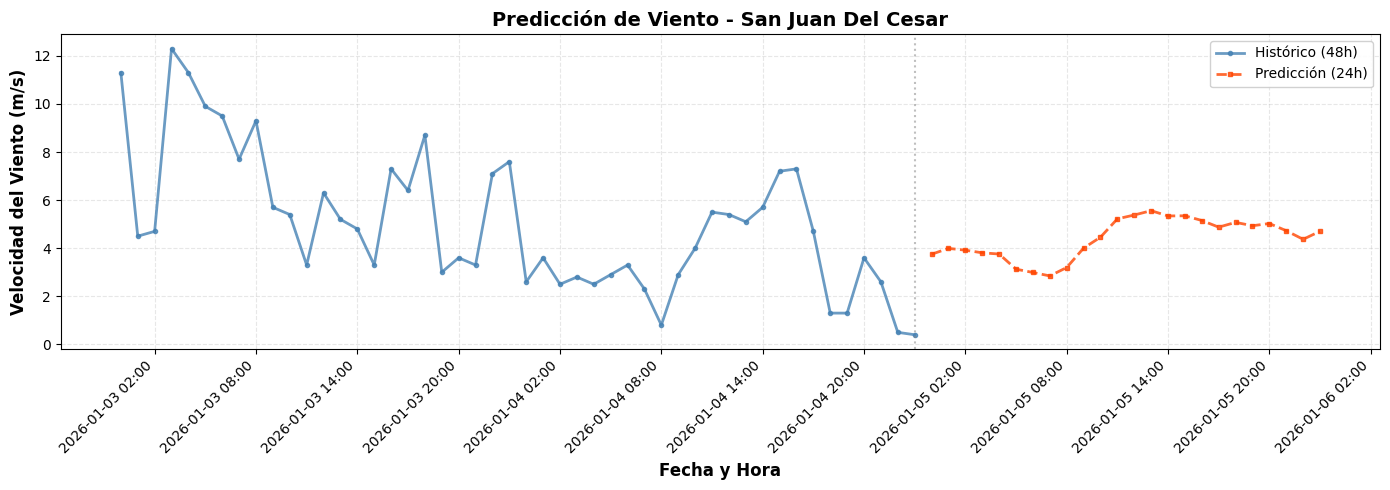


📊 SAN_JUAN_DEL_CESAR
Histórico: 0.40 - 12.30 m/s (Media: 5.05)
Predicción: 2.85 - 5.56 m/s (Media: 4.40)
Último valor histórico: 0.40 m/s
Primera predicción: 3.75 m/s
Diferencia: 3.35 m/s


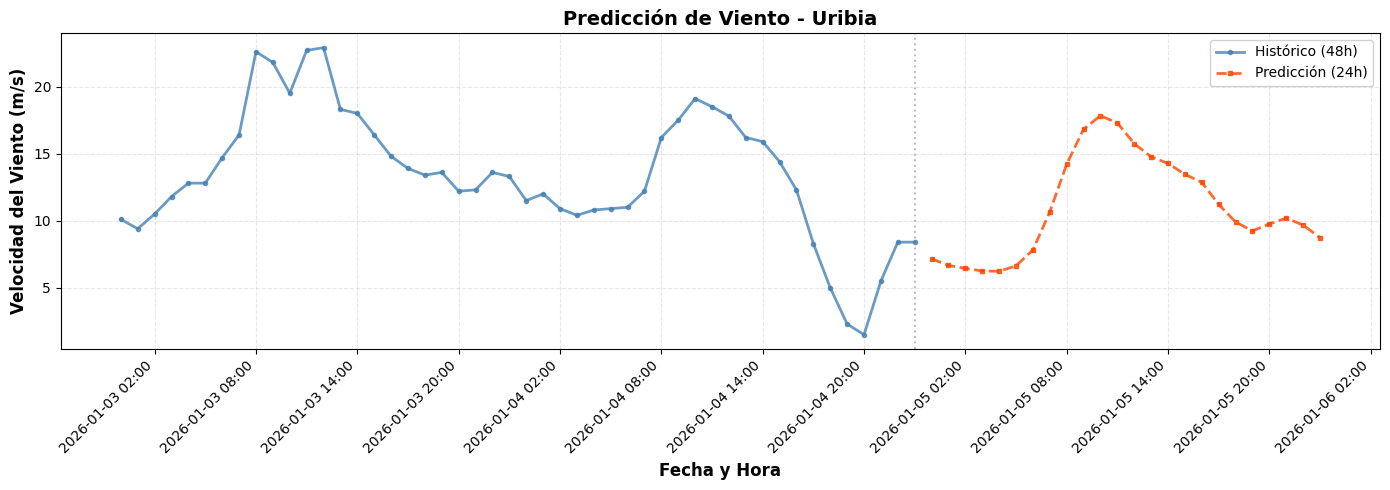


📊 URIBIA
Histórico: 1.50 - 22.90 m/s (Media: 13.43)
Predicción: 6.23 - 17.83 m/s (Media: 10.99)
Último valor histórico: 8.40 m/s
Primera predicción: 7.17 m/s
Diferencia: -1.23 m/s


In [9]:
for mun in municipios:
    # Datos históricos (ventana de 48 horas)
    historical_times = data_48h[mun]['datetime']
    historical_wind = data_48h[mun]['wind_speed_10m']
    
    # Predicciones (próximas 24 horas)
    forecast_times = predictions[mun]['datetime']
    forecast_wind = predictions[mun]['predicted_wind_speed_10m']
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Graficar ventana histórica (48h)
    ax.plot(historical_times, historical_wind, 
            marker='o', markersize=3, linewidth=2, 
            color='steelblue', label='Histórico (48h)', alpha=0.8)
    
    # Graficar predicción (24h)
    ax.plot(forecast_times, forecast_wind, 
            marker='s', markersize=3, linewidth=2, 
            color='orangered', label='Predicción (24h)', linestyle='--', alpha=0.8)
    
    # Línea vertical separando histórico de predicción
    ax.axvline(x=historical_times.iloc[-1], color='gray', 
               linestyle=':', linewidth=1.5, alpha=0.5)
    
    # Formatear eje X
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    plt.xticks(rotation=45, ha='right')
    
    # Etiquetas y título
    ax.set_xlabel('Fecha y Hora', fontsize=12, fontweight='bold')
    ax.set_ylabel('Velocidad del Viento (m/s)', fontsize=12, fontweight='bold')
    ax.set_title(f'Predicción de Viento - {mun.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    
    # Leyenda y grid
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    print(f"\n{'='*60}")
    print(f"📊 {mun.upper()}")
    print(f"{'='*60}")
    print(f"Histórico: {historical_wind.min():.2f} - {historical_wind.max():.2f} m/s (Media: {historical_wind.mean():.2f})")
    print(f"Predicción: {min(forecast_wind):.2f} - {max(forecast_wind):.2f} m/s (Media: {sum(forecast_wind)/len(forecast_wind):.2f})")
    print(f"Último valor histórico: {historical_wind.iloc[-1]:.2f} m/s")
    print(f"Primera predicción: {forecast_wind.iloc[0]:.2f} m/s")
    print(f"Diferencia: {(forecast_wind.iloc[0] - historical_wind.iloc[-1]):.2f} m/s")


In [10]:
conn.close()
